In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml
import pickle
import os
import time

from utils.generate_data import *
from utils.sub_sampler import *
from utils.compute_barycenter import *
from utils.general_utils import *

data_path = 'data'

### Paper's Gaussian mixture experiment

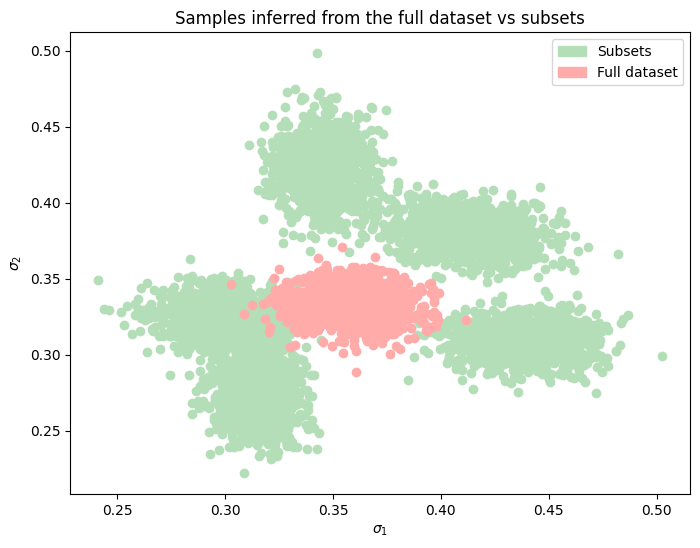

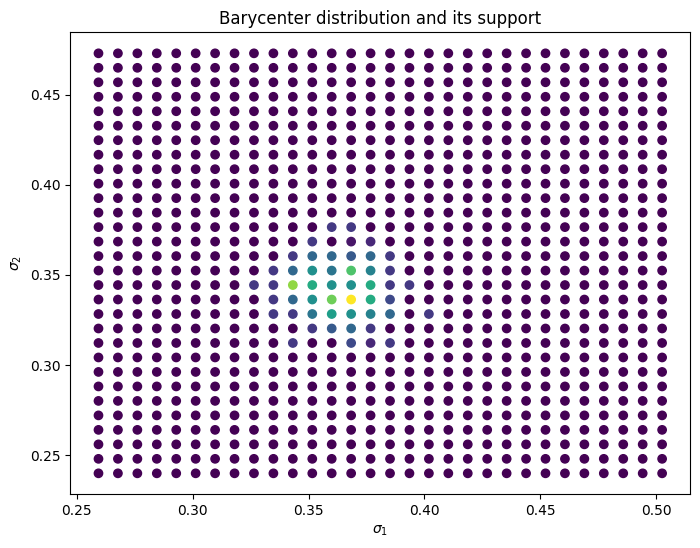

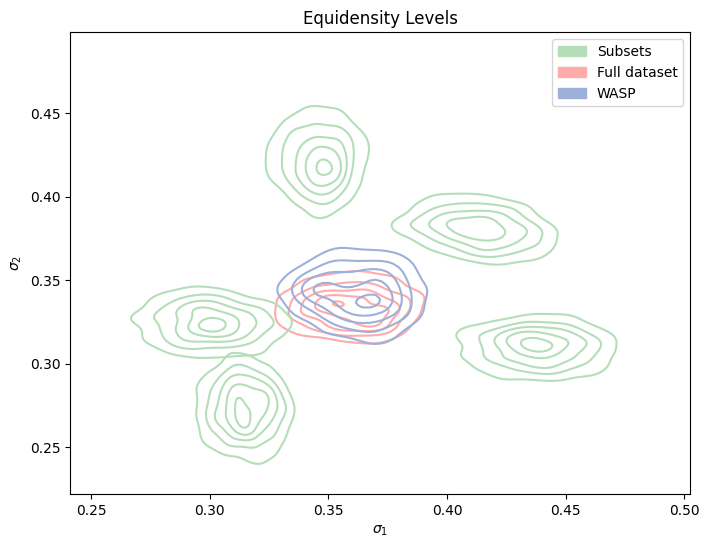

In [2]:
output = process_results('experience_1.yaml', proj='rho_1', npart=5)

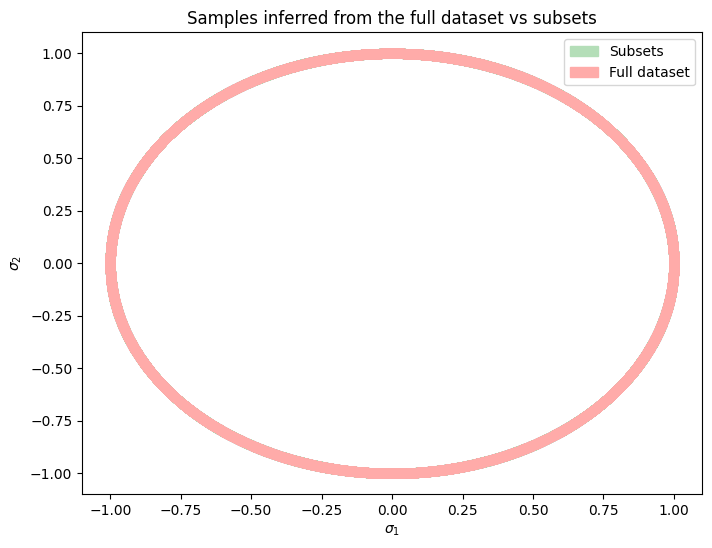

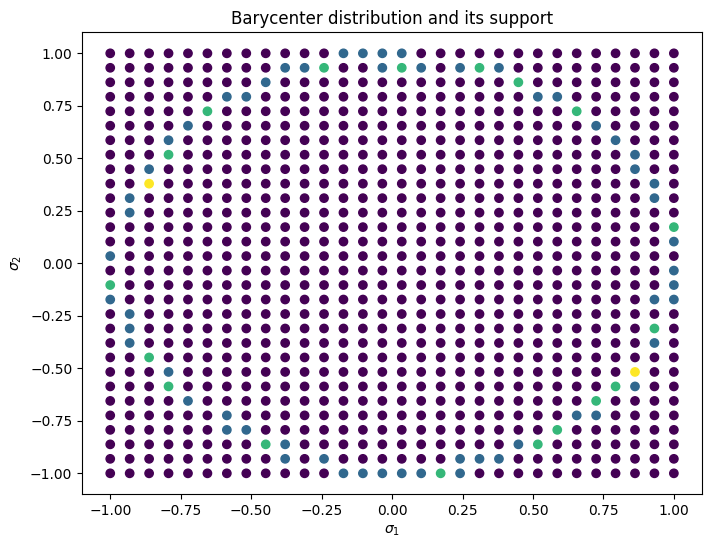

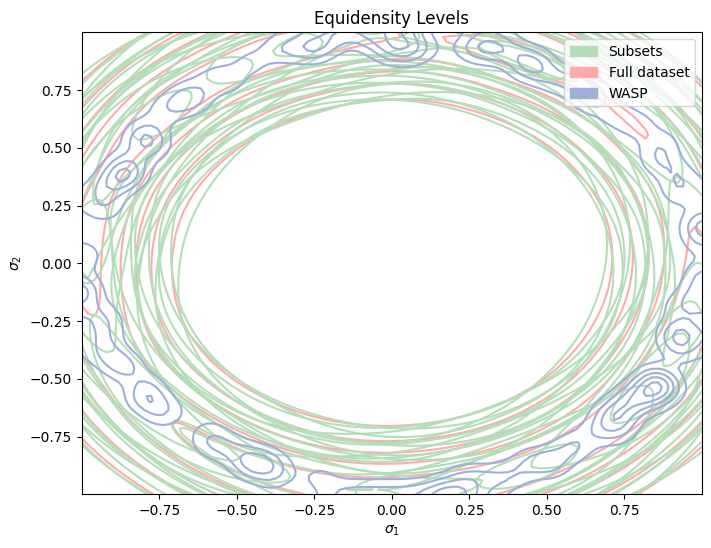

In [6]:
output = process_results('experience_logistic_regression.yaml', proj='identity_log', npart=5)